In [1]:
import numpy as np
from image_alignment import ImageAligner
from datalib import *
from skimage import io
import os
from scipy.ndimage import gaussian_filter
import pandas

%matplotlib widget

wavelength_to_index = lambda x, wavelengths: np.argmin( np.abs( wavelengths - x ) )

In [2]:
%load_ext autoreload

In [3]:
%autoreload 1
%autoreload 2

# 1. Load the two modalities

## 1.1 LIBS

In [4]:
file_libs_metadata = r'E:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma/LIBS/Kopie souboru 403x540-P36B-Avantes.libsmetadata.txt'
file_libs_data = r"E:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma/LIBS/Kopie souboru 403x540-P36B-Avantes.libsdata"

libs_manipulator = MapData(file_path = file_libs_data)
libs_manipulator.load_wavelenths()
libs_manipulator.load_all_data('libs')
libs_manipulator.baseline_correct()

libs_manipulator.get_map_dimensions()
nx, ny = libs_manipulator.map_dimensions
spectrum = libs_manipulator.spectra.reshape(ny, nx, -1)
wavelengths = libs_manipulator.wvl

# Correct flipped dimensions
spectrum[1::2, :] = spectrum[1::2, ::-1]

loading wavelengths
loading metadata
preprocessed file was not found; setting overwrite to True
loading raw data
getting baselines
getting map dimensions


In [87]:
modality1 = spectrum[::, :, wavelength_to_index(393.353, wavelengths)]

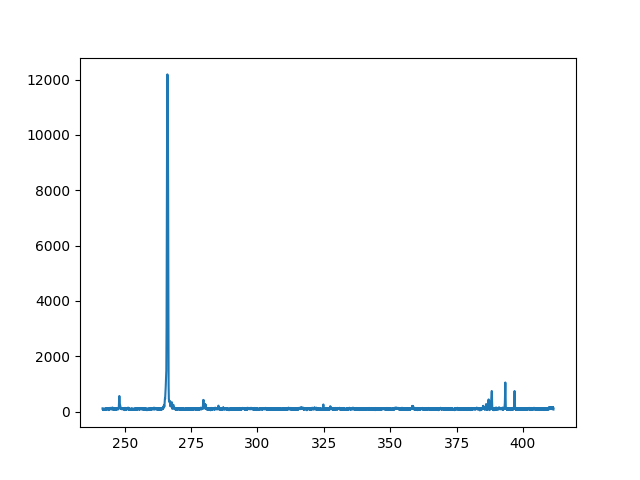

In [6]:
plt.figure()
plt.plot(wavelengths, np.max(spectrum, axis = (0, 1)))

## 1.2 ICP-MS

In [7]:
main_dir = r"E:/Data/Data_LIBS/Data_Brno/"
sample_dir = r"P36 - Epithelioid angiosarcoma//"
dir_ICP = main_dir + sample_dir + r"LA-ICP-MS//P36B//Export//"

def read_metadata(file1):
    df = pandas.read_csv(file1,encoding = "ISO-8859-1",header=None)
    map_dims = [float(df[1][0].split('x')[0]),float(df[1][0].split('x')[1])]
    spot_dims = [float(df[1][1].split('x')[0]),float(df[1][1].split('x')[1])]
    return map_dims, spot_dims

def read_icp(folder, name='Total'):
    file1 = [folder+'//'+f for f in os.listdir(folder) if f.endswith('csv') and 'metadata' in f]
    print(file1)
    map_dims, spot_dims = read_metadata(file1[0])
    files = [folder+'//'+f for f in os.listdir(folder) if f.endswith('csv') and name in f]
    df = pandas.read_csv(files[0],encoding = "ISO-8859-1",header=None)
    df = df.fillna(0)
    data = df.to_numpy()
    data-=data.min()+1
    return map_dims, spot_dims, data

names_ICP = ['Mg','Cu','Fe']
_, _, data = read_icp(dir_ICP,name=names_ICP[0])
modality2 = abs(data)**(0.3)

['E:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma//LA-ICP-MS//P36B//Export////P36 metadata.csv']


## 1.3 Modalitiies

C:\Users\tomas\AppData\Local\Temp\ipykernel_20424\631537035.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize = (10, 4))


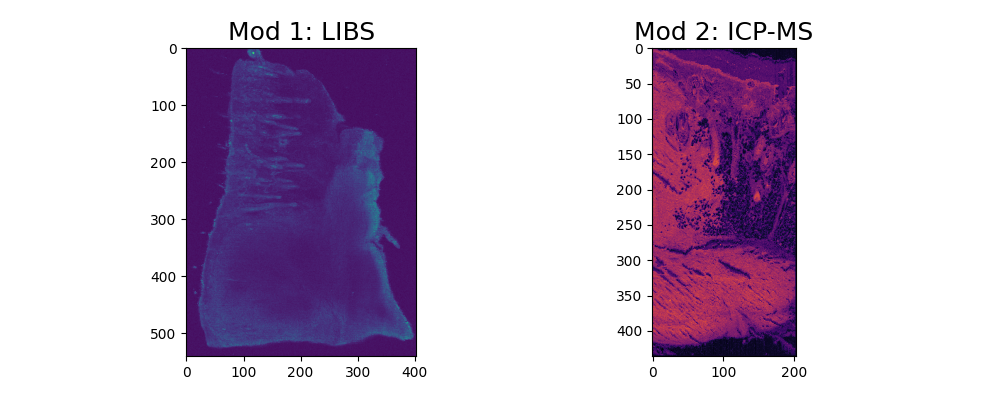

In [88]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

ax = axs[0]
ax.set_title('Mod 1: LIBS', fontsize = 18)
ax.imshow(modality1, cmap = 'viridis')

ax = axs[1]
ax.set_title('Mod 2: ICP-MS', fontsize = 18)
ax.imshow(modality2, cmap = 'inferno')

# 2. Align

In [186]:
# Downsample and Apply Gaussian Filter to reduce noise
%matplotlib widget
step_mod1 = 1
mod1 = gaussian_filter(modality1[::step_mod1, ::step_mod1], sigma = 3)
mod1 = np.array(mod1)

step_mod2 = 1
mod2 = np.rot90(gaussian_filter(modality2[::step_mod2, ::step_mod2], sigma  = 3))
mod2 = np.array(mod2)

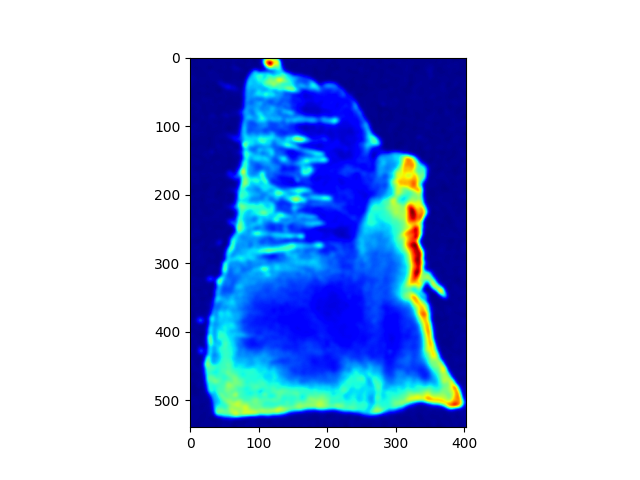

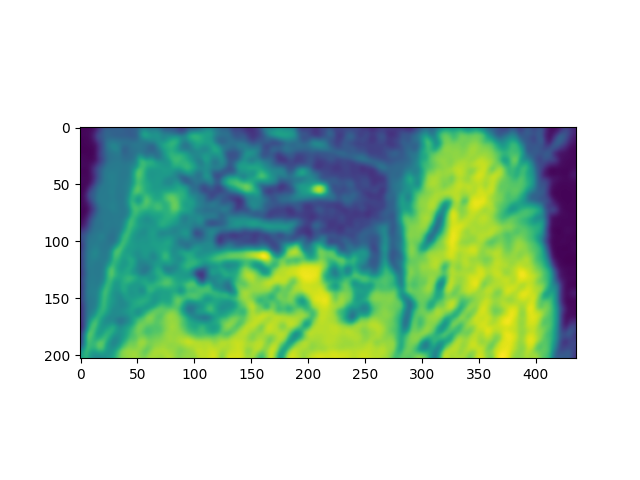

In [187]:
plt.figure()
plt.imshow(mod1, cmap = 'jet')

plt.figure()
plt.imshow(mod2)

## 2.1 Manual Alingment

In [192]:
aligner = ImageAligner(mod1, mod2, device = 'cuda')

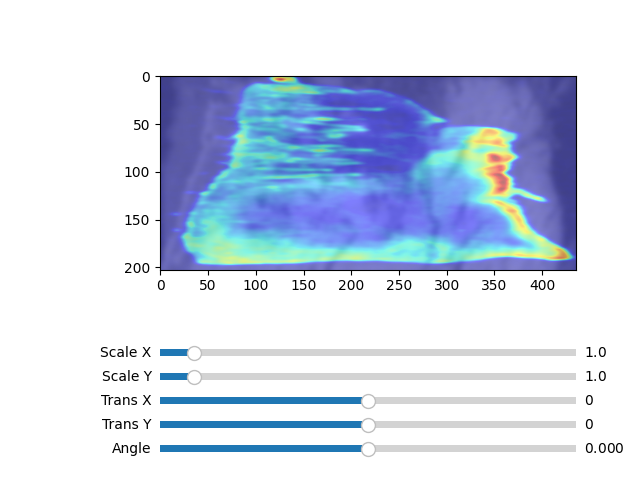

In [193]:
%matplotlib widget
initial_params = aligner.manual_align()

## 2.2 Automatic Fine Tuning

In [194]:
optimizer_params = {
    'optim': 'Adam', # Se confiante no alinhamento manual -> Adam, caso contrário -> SGD
    'lr': 1e-2, # 1e-3 a 1e-4
    'momentum': 0.8, # 0.8 a 0.9
    'num_iters': 1000,
}

transform_params = {
    's_tol': 6,
    't_tol': 0.2,
    'a_tol': 0.2,
    'edge_align': False # Amostras com pouca estrutura
}

In [195]:
final_params = aligner.auto_align(optimizer_params, transform_params)
print("Final alignment parameters:", final_params)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


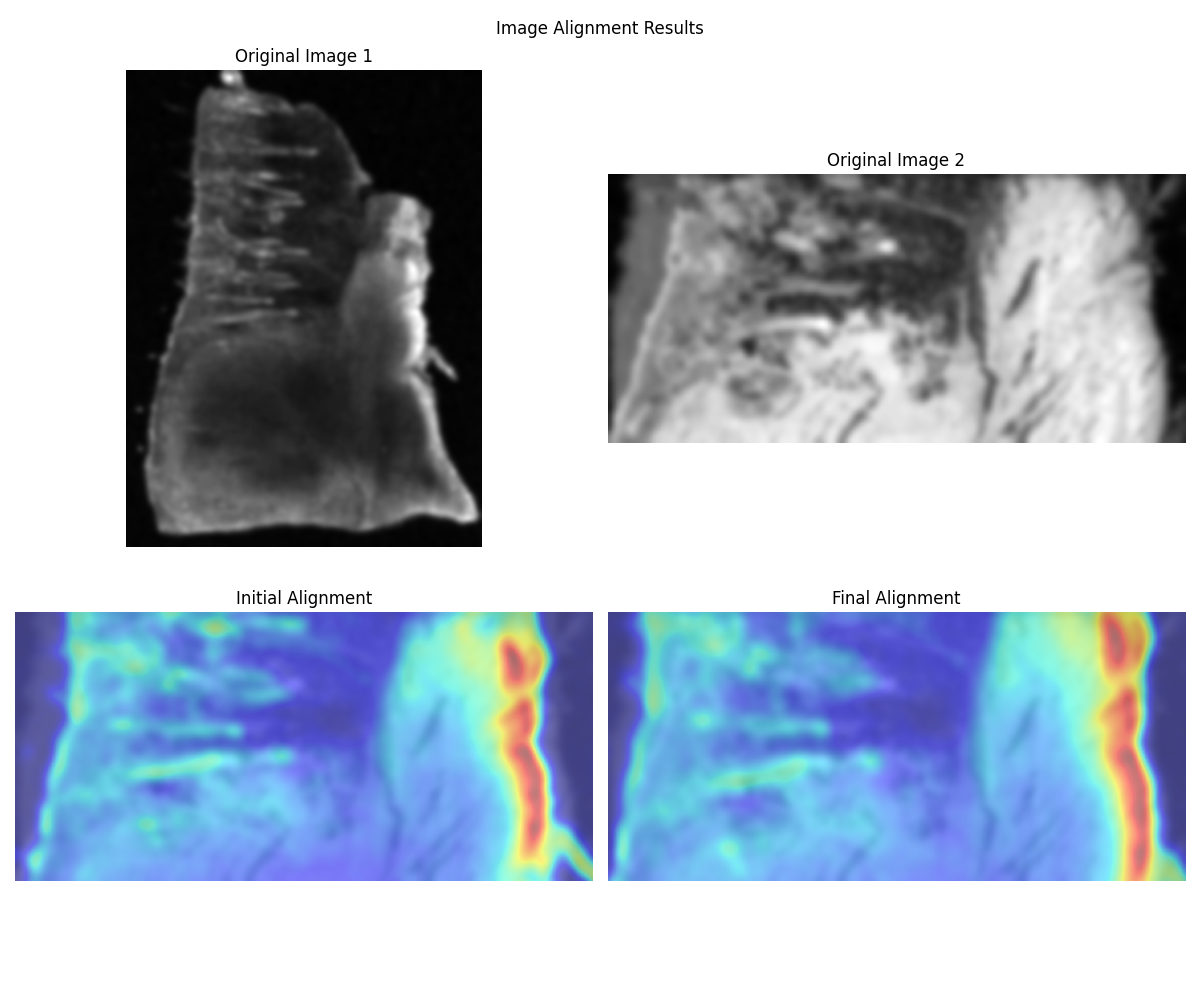

In [168]:
aligner.plot_alignment()

# 2.3 Align Entire Dataset

In [180]:
libs_new_grid = aligner.align_dataset(spectrum, mod2.shape)

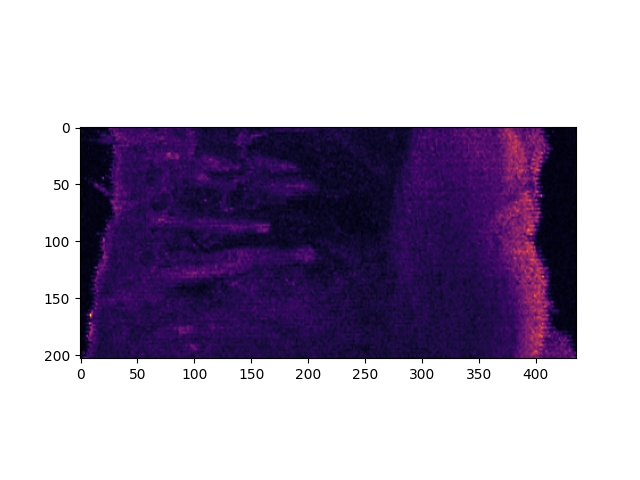

In [185]:
plt.figure()
plt.imshow(libs_new_grid[:, :, wavelength_to_index(393.353, wavelengths)], cmap = 'inferno')